<a href="https://colab.research.google.com/github/cmcshaffrey/hiddeneigenmice/blob/main/Connor's_Awesome_Random_Samples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import libraries 
import ipywidgets as widgets

## Loading of Stringer spontaneous data

includes some visualizations

In [3]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [4]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [5]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])



dat has fields:
* `dat['sresp']`: neurons by timebins, a.k.a. the neural response data (14752 by 8118). Timebin = 1.2 sec.
* `dat['run']`: timebins by 1, a.k.a. the running speed of the animal in a.u.
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['pupilArea']`: timebins by 1, see FaceMap for details on the pupil tracker
* `dat['pupilCOM']`: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* `dat['beh_svd_time']`: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details. 
* `dat['beh_svd_mask']`: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other. 
* `dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]`:  reconstruction of the face movie (its motion energy) for frame T
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.

In [6]:
print(dat['sresp'].shape)
print(len(dat['stat']))

(11983, 7018)
11983


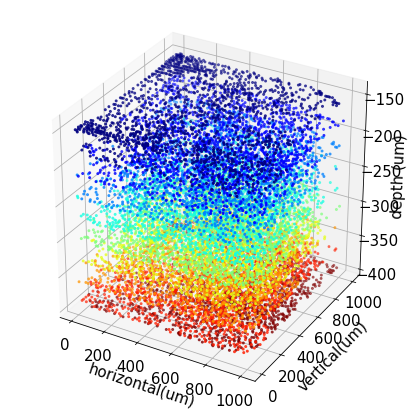

In [7]:
# @title plot the 3D positions of all neurons
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x, y, z = dat['xyz']

zunq, iunq = np.unique(z, return_inverse=True)
xc = np.linspace(0.0, 1.0, len(zunq))
cmap = cm.get_cmap('jet')(xc)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::-1],y[::-1],z[::-1], 'o', s = 4, c = cmap[iunq])
ax.set(xlabel='horizontal(um)', ylabel = 'vertical(um)', zlabel='depth (um)');

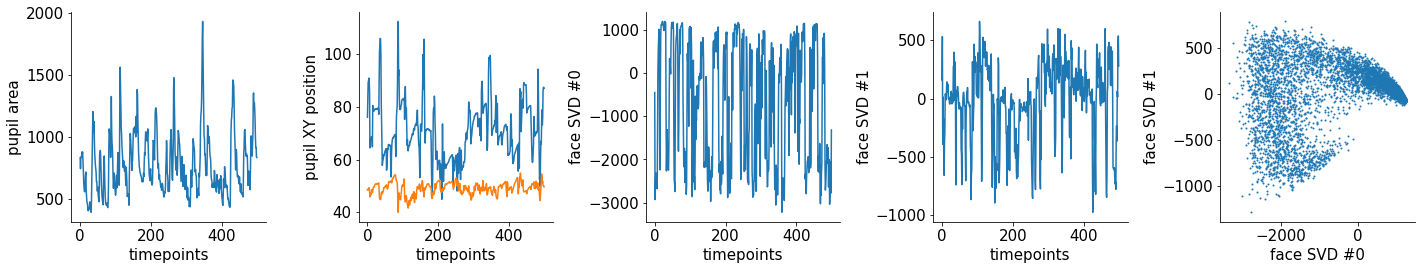

In [8]:
#@title Basic properties of behavioral data using plot and scatter
ax = plt.subplot(1,5,1)
plt.plot(dat['pupilArea'][:500,0])
ax.set(xlabel='timepoints', ylabel = 'pupil area')

ax = plt.subplot(1,5,2)
plt.plot(dat['pupilCOM'][:500,:])
ax.set(xlabel='timepoints', ylabel = 'pupil XY position')

ax = plt.subplot(1,5,3)
plt.plot(dat['beh_svd_time'][:500,0])
ax.set(xlabel='timepoints', ylabel = 'face SVD #0')

ax = plt.subplot(1,5,4)
plt.plot(dat['beh_svd_time'][:500,1])
ax.set(xlabel='timepoints', ylabel = 'face SVD #1')

ax = plt.subplot(1,5,5)
plt.scatter(dat['beh_svd_time'][:,0], dat['beh_svd_time'][:,1], s = 1)
ax.set(xlabel='face SVD #0', ylabel = 'face SVD #1')

plt.show()

In [9]:
#@title take PCA after preparing data by z-score
from scipy.stats import zscore
from sklearn.decomposition import PCA 
Z = zscore(dat['sresp'], axis=1)
Z = np.nan_to_num(Z)
X = PCA(n_components = 200).fit_transform(Z)

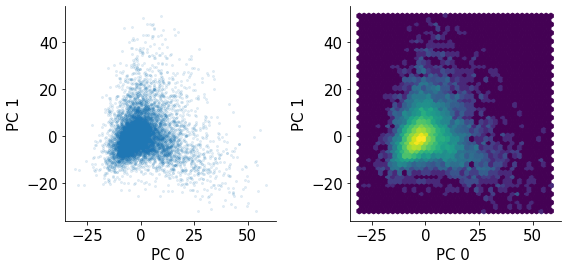

In [10]:
#@title Plot PCs. Too many points, switch to logarithmic hexbin! 
ax = plt.subplot(1,5,1)
plt.scatter(X[:,0], X[:,1], s = 4, alpha = .1)
ax.set(xlabel = 'PC 0 ', ylabel = 'PC 1');

ax = plt.subplot(1,5,2)
plt.hexbin(X[:,0], X[:,1], gridsize = 40, bins = 'log')
ax.set(xlabel = 'PC 0 ', ylabel = 'PC 1', alpha = .1);

In [11]:
#@title run a manifold embedding algorithm (UMAP) in two or three dimensions. 
!pip install umap-learn
from umap import UMAP
ncomp = 1 # try 2, then try 3
xinit = 1 * zscore(X[:,:ncomp], axis=0)
embed = UMAP(n_components=ncomp, init =  xinit, n_neighbors = 20, 
             metric = 'correlation', transform_seed = 42).fit_transform(X)
             

     |████████████████████████████████| 81kB 2.6MB/s 
     |████████████████████████████████| 1.1MB 9.5MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=16d08e4533dce356aa4ef809b295fd146db9123e039a4e49b63ce54655111391
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.4-cp37-none-any.whl size=52374 sha256=ddd05759671c9337c95acf6365d51bc6e5e2ed41c53aa7c5f68286fb02838918
  Stored in directory: /root/.cache/pip/wheels/42/4b/8c/f6f119c67cf6583bb192431fa8f7278cf95e5b943055077d94
Successfully built umap-learn pynndescent


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [12]:
from scipy.ndimage import uniform_filter1d
embed = embed.flatten()
isort = np.argsort(embed)
RasterMap = uniform_filter1d(Z[isort, :], size= 50, axis=0)
RasterMap = zscore(RasterMap[::10, :], axis = 1)

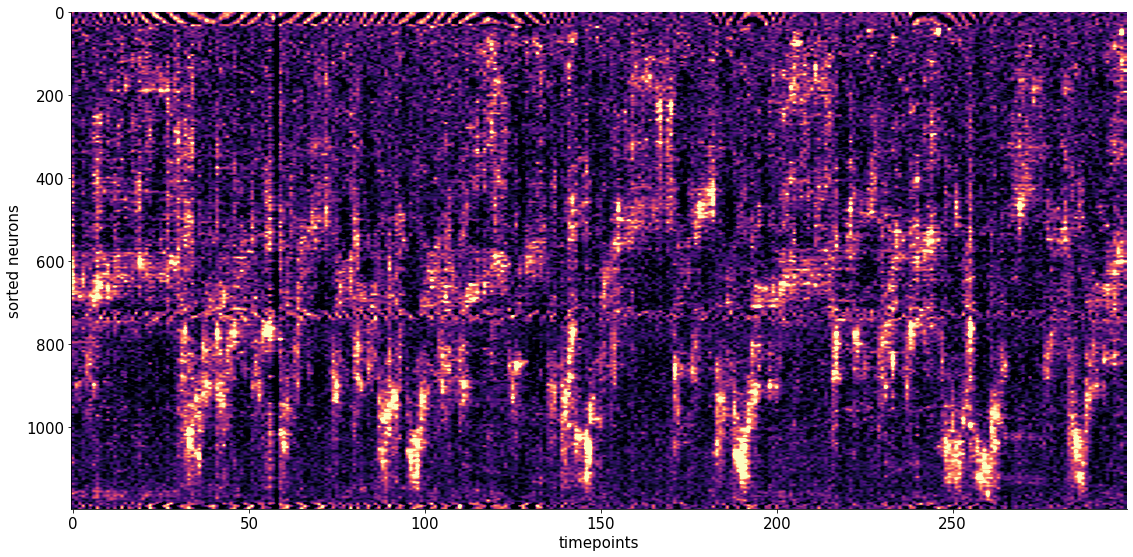

In [13]:
plt.figure(figsize=(16,8))
ax = plt.subplot(111)
trange = np.arange(1100, 1400)
plt.imshow(RasterMap[:, trange], vmax= 3, vmin = -1, aspect = 'auto', cmap = 'magma')
ax.set(xlabel = 'timepoints', ylabel = 'sorted neurons');

In [13]:
# now sort with UMAP both the neuron axis and the timepoints axis, bin the sorted matrix and make a sorted Rastermap picture 

--- 
# Project 

In [14]:
#@title Make design matrix
def make_design_matrix(x, order):
  """Create the design matrix of inputs for use in polynomial regression

  Args:
    x (ndarray): input vector of shape (n_samples)
    order (scalar): polynomial regression order

  Returns:
    ndarray: design matrix for polynomial regression of shape (samples, order+1)
  """
  ########################################################################
  ## TODO for students: create the design matrix ##
  # Fill out function and remove
  # raise NotImplementedError("Student exercise: create the design matrix")
  ########################################################################

  # Broadcast to shape (n x 1) so dimensions work
  if x.ndim == 1:
    x = x[:, None]

  #if x has more than one feature, we don't want multiple columns of ones so we assign
  # x^0 here
  design_matrix = np.ones((x.shape[0], 1))

  # Loop through rest of degrees and stack columns (hint: np.hstack)
  for degree in range(1, order + 1):
      design_matrix = np.hstack((design_matrix, x**degree))

  return design_matrix

In [15]:
#@title Ordinary Least Squares 
def ordinary_least_squares(X, y):
  """Ordinary least squares estimator for linear regression.

  Args:
    x (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vector of measurements of shape (n_samples)

  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """
  ######################################################################
  ## TODO for students: solve for the optimal parameter vector using OLS
  # Fill out function and remove
  # raise NotImplementedError("Student exercise: solve for theta_hat vector using OLS")
  ######################################################################

  # Compute theta_hat using OLS
  theta_hat = np.linalg.inv(X.T @ X) @ X.T @ y 

  # Compute y_hat 
  y_hat = X @ theta_hat

  # Compute residuals 
  residuals = y - y_hat

  return theta_hat, y_hat, residuals 

In [16]:
def plot_run_neuron(neuron_idx):

  # Visualize data 
  plt.figure();
  plt.scatter(dat['run'], dat['sresp'][neuron_idx,:]);

  # OLS 
  theta_hat, y_hat, residuals = ordinary_least_squares(X=make_design_matrix(dat['run'], 1), y=dat['sresp'][neuron_idx,:])
  plt.plot(dat['run'], y_hat, color='k')

  # finish plot 
  plt.xlabel('Run speed (a.u.)'); plt.ylabel('Neuron response');
  plt.title(f'Neuron {neuron_idx} \n beta_0 = {theta_hat[0]:.2f}, beta_1 = {theta_hat[1]:.2f}')
  plt.show();

  # plot residuals 
  plt.figure();
  plt.scatter(dat['run'], residuals,color='r', label='residuals');
  plt.axhline(0, linestyle='--')
  plt.xlabel('Run speed (a.u.)'); plt.ylabel('Residuals');
  plt.legend()
  plt.show()

_ = widgets.interact(plot_run_neuron, neuron_idx=(0,np.shape(dat['sresp'])[0],1))

interactive(children=(IntSlider(value=5991, description='neuron_idx', max=11983), Output()), _dom_classes=('wi…

In [17]:
def plot_pupilArea_neuron(neuron_idx):
  
  # visualize data 
  plt.figure();
  plt.scatter(dat['pupilArea'], dat['sresp'][neuron_idx,:]);
  
  # OLS 
  theta_hat, y_hat, residuals = ordinary_least_squares(X=make_design_matrix(dat['pupilArea'], 1), y=dat['sresp'][neuron_idx,:])
  plt.plot(dat['pupilArea'], y_hat, color='k')

  plt.xlabel('Pupil Area'); plt.ylabel('Neuron response'); 
  plt.title(f'Neuron {neuron_idx} \n beta_0 = {theta_hat[0]:.2f}, beta_1 = {theta_hat[1]:.2f}')
  plt.show();

  # plot residuals 
  plt.figure();
  plt.scatter(dat['pupilArea'], residuals, color='r', label='residuals');
  plt.axhline(0, linestyle='--')
  plt.xlabel('Pupil Area'); plt.ylabel('Residuals');
  plt.legend()
  plt.show()

_ = widgets.interact(plot_pupilArea_neuron, neuron_idx=(0,np.shape(dat['sresp'])[0],1))

interactive(children=(IntSlider(value=5991, description='neuron_idx', max=11983), Output()), _dom_classes=('wi…

In [18]:
def plot_neuron_run(neuron_idx):

  # Visualize data 
  plt.figure();
  plt.scatter(dat['sresp'][neuron_idx,:], dat['run']);

  # OLS 
  theta_hat, y_hat, residuals = ordinary_least_squares(X=make_design_matrix(dat['sresp'][neuron_idx,:], 1), y=dat['run'])
  plt.plot(dat['sresp'][neuron_idx,:],y_hat, color='k')

  # finish plot 
  plt.xlabel('Neuron response'); plt.ylabel('Run speed (a.u.)'); 
  plt.title(f'Neuron {neuron_idx} \n beta_0 = {theta_hat[0][0]:.2f}, beta_1 = {theta_hat[1][0]:.2f}')
  plt.show();

  # plot residuals 
  plt.figure();
  plt.scatter(dat['sresp'][neuron_idx,:], residuals,color='r', label='residuals');
  plt.axhline(0, linestyle='--')
  plt.xlabel('Neuron response'); plt.ylabel('Residuals');
  plt.legend()
  plt.show()

_ = widgets.interact(plot_neuron_run, neuron_idx=(0,np.shape(dat['sresp'])[0],1))

interactive(children=(IntSlider(value=5991, description='neuron_idx', max=11983), Output()), _dom_classes=('wi…

In [19]:
def plot_neuron_pupilArea(neuron_idx):
  
  # visualize data 
  plt.figure();
  plt.scatter(dat['sresp'][neuron_idx,:], dat['pupilArea']);
  
  # OLS 
  theta_hat, y_hat, residuals = ordinary_least_squares(X=make_design_matrix(dat['sresp'][neuron_idx,:], 1), y=dat['pupilArea'])
  plt.plot(dat['sresp'][neuron_idx,:], y_hat, color='k')

  plt.xlabel('Neuron response'); plt.ylabel('Pupil Area'); 
  plt.title(f'Neuron {neuron_idx} \n beta_0 = {theta_hat[0][0]:.2f}, beta_1 = {theta_hat[1][0]:.2f}')
  plt.show();

  # plot residuals 
  plt.figure();
  plt.scatter(dat['sresp'][neuron_idx,:], residuals, color='r', label='residuals');
  plt.axhline(0, linestyle='--')
  plt.xlabel('Residuals'); plt.ylabel('Pupil Area'); 
  plt.legend()
  plt.show()

_ = widgets.interact(plot_neuron_pupilArea, neuron_idx=(0,np.shape(dat['sresp'])[0],1))

interactive(children=(IntSlider(value=5991, description='neuron_idx', max=11983), Output()), _dom_classes=('wi…

# Random Sampling of Data (1/10th)

```
# This is formatted as code
```



In [25]:
## Bootstrapped random selection for dimensionality reduction
neuron_dat = dat['sresp']

print(neuron_dat.shape)
print(len(neuron_dat))

### Need to make a f(x) that takes in a matrix and returns ~10% of 
### the rows at random. 

def tenth_sample_random(X):
  #The f(x) needs to know how many neurons there are
  number_neuro = len(X)
  #I need to tell it how many samples to actually take, rounded to an integer
  tenth_neuro = np.ceil(int(number_neuro / 10))
  #For each count in tenth_neuro, I need to sample from the matrix
  indices = np.random.choice(X.shape[0], int(tenth_neuro), replace=False)
  #Save it as a new matrix I guess
  sampled_neurons = X[indices]
  #Annnnd spit that out
  return sampled_neurons


(11983, 7018)
11983


In [27]:
#Testing of the random selection...huzzah

A=tenth_sample_random(neuron_dat)

print(A.shape)
print(len(A))

(1198, 7018)
1198
